In [1]:
# Import Libraries
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
from imageio import imread, imwrite
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
# Step1: Load Image
# Function that checks if the image is loaded in the requested formats(.png,.jpeg,.tiff). If not, user notification for unsupported format
def check_image_format(image_path):
    # Check if file exists
    if not os.path.exists(image_path):
        print("File doesn't exist.")
        return None

    # If it exists, check format
    try:
        image = Image.open(image_path)
        image_format = image.format

        if image_format in ['PNG', 'JPEG', 'TIFF']:
            print(f"Image in correct format! Format: {image.format}")
            return image
        else:
            print("Invalid Format. Try loading image in PNG/JPEG/TIFF form")
            return None
            
    except IOError as e:
        print(f"Error loading image: {e}")
        return None
        

In [3]:
# Step2: Apply different filters
def apply_filters(image_path, filter_type):
    try:
        image = Image.open(image_path)
    except IOError as e:
        print(f"Error loading image: {e}")
        return None
        
    # Change the colored image into greyscale
    if filter_type == 'grayscale':
        grayscale_image = ImageOps.grayscale(image)
        return grayscale_image

    # Changes color of image by its complementary color
    elif filter_type == 'negative':
        negative_image = ImageOps.invert(image.convert("RGB"))
        return negative_image
        
    # Apply Gaussian blur with the specified radius
    elif filter_type == 'gaussian_smoothing':
        radius = float(input("Enter radius: "))
        smoothed_image = image.filter(ImageFilter.GaussianBlur(radius))
        return smoothed_image

    # Apply Bilateral smoothing
    elif filter_type == 'bilateral_smoothing':
        # Convert Pillow image to a format suitable for OpenCV
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        # Enter inputs
        bilateral_diameter = int(input("Enter diameter: "))
        sigma_color = float(input("Enter sigma color: "))
        sigma_space = float(input("Enter sigma space: "))
        
        # Apply bilateral filter
        smoothed_image_cv = cv2.bilateralFilter(image_cv, bilateral_diameter, sigma_color, sigma_space)
        
        # Convert back to Pillow image
        smoothed_image = Image.fromarray(cv2.cvtColor(smoothed_image_cv, cv2.COLOR_BGR2RGB))
        return smoothed_image
        
    # Changes the brightness of the image
    elif filter_type == 'brightness':
        brightness_factor = float(input("Enter brightness factor: "))
        enhancer = ImageEnhance.Brightness(image)
        brightness_image = enhancer.enhance(brightness_factor)
        return brightness_image

    # Swaps the red and blue channels of the image.  
    # RGB -> BGR
    elif filter_type == 'color_swap':
        r, g, b = image.split()
        swap_image = Image.merge("RGB", (b, g, r))
        return swap_image

    # Enhance the edges of the image
    elif filter_type == 'edge_enhancement':
        edge_enhanced_image = image.filter(ImageFilter.EDGE_ENHANCE)
        return edge_enhanced_image

    elif filter_type == 'edge_enhancement_more':
        edge_enhanced_image = image.filter(ImageFilter.EDGE_ENHANCE_MORE)
        return edge_enhanced_image
    
        
    else:
        print("Invalid filter.")
        return None

In [4]:
# Function that detects face and eyes
def detect_face_and_eyes(image_path):
    # Load the pre-trained Haar Cascade classifier for face and eyes detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    # Read image
    image = cv2.imread(image_path)

    # Convert image to greyscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect face
    # face = face_cascade.detectMultiScale(gray)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Initialize list for detected eyes
    eyes_detected = []

    for (x,y,w,h) in faces:
        center = (x + w//2, y + h//2)
        # image = cv2.ellipse(image, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        # image = cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 255), 4)
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

        faceROI = gray[y:y+h,x:x+w]

        # In each face, detect eyes
        eyes = eye_cascade.detectMultiScale(faceROI)

        for (x2,y2,w2,h2) in eyes:
            eye_center = (x + x2 + w2//2, y + y2 + h2//2)
            radius = int(round((w2 + h2)*0.25))
            # Draw rectangles around the eyes
            # cv2.rectangle(gray, (x + x2, y + y2), (x + x2 + w2, y + y2 + h2), (255, 0, 0), 2)

            # cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            cv2.circle(image, eye_center, radius, (255, 0, 0), 4)
            eyes_detected.append((x + x2, y + y2, w2, h2))  # Append detected eye coordinates to the list

    # Display the image
    # cv2.imshow('Capture - Face detection', image)
    # cv2.waitKey(0)  # Wait for a key press to close the window
    # cv2.destroyAllWindows()

    return image, faces, eyes_detected

In [5]:
def detect_lines(image_path):
    # Read image
    image = cv2.imread(image_path)

    # Convert to greyscale for edge detection
    grayscale_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Use Canny edge detector
    detected_edges = cv2.Canny(grayscale_img, 50, 150, apertureSize=3)

    # Apply HoughLinesP method to 
    # to directly obtain line end points
    lines_list =[]
    lines = cv2.HoughLinesP(
            detected_edges, # Input edge image
            1, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=100, # Min number of votes for valid line
            minLineLength=5, # Min allowed length of line
            maxLineGap=10 # Max allowed gap between line for joining them
            )
 
    # Iterate over points
    for points in lines:
        # Extracted points nested in the list
        x1,y1,x2,y2=points[0]
        # Draw the lines joing the points
        # On the original image
        cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2)
        # Maintain a simples lookup list for points
        lines_list.append([(x1,y1),(x2,y2)])

    return image,lines

In [6]:
def detect_circles(image_path):
    # Read image
    image = cv2.imread(image_path)

    # Convert to greyscale for edge detection
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Blur using 3 * 3 kernel. 
    gray_blurred = cv2.medianBlur(grayscale_image, 5)

    # Apply Hough transform on the blurred image. 
    detected_circles = cv2.HoughCircles(gray_blurred,  
                   cv2.HOUGH_GRADIENT, 1, 20, param1 = 50, 
               param2 = 30, minRadius = 1, maxRadius = 40) 
  
    # Draw circles that are detected. 
    if detected_circles is not None: 
  
        # Convert the circle parameters a, b and r to integers. 
        detected_circles = np.uint16(np.around(detected_circles)) 
  
        for pt in detected_circles[0, :]: 
            a, b, r = pt[0], pt[1], pt[2] 
  
            # Draw the circumference of the circle. 
            cv2.circle(image, (a, b), r, (0, 255, 0), 2) 
  
    return image, detected_circles
    

In [7]:
def add_hat(image_path, hat_path):
    width = 1.2
    height = 0.9

    # Load with alpha channel
    hat = cv2.imread(hat_path, -1) 
    image, faces, eyes = detect_face_and_eyes(image_path)
    image_with_hat = cv2.imread(image_path)

    for (x, y, w, h) in faces:
        hat_width = int(w * width)
        hat_height = int(h * height)
        hat_resized = cv2.resize(hat, (hat_width, hat_height))

        shift_left = 10
        hat_x = x - int((hat_width - w) / 2) - shift_left
        hat_y = y - int(hat_height * 0.8)
        
        if hat_y < 0 or hat_x < 0 or hat_x + hat_width > image_with_hat.shape[1] or hat_y + hat_height > image_with_hat.shape[0]:
            continue

        alpha_s = hat_resized[:, :, 3] / 255.0
        alpha_l = 1.0 - alpha_s

        for c in range(0, 3):
            overlay_slice = image_with_hat[hat_y:hat_y+hat_height, hat_x:hat_x+hat_width, c]
            resized_slice = hat_resized[:, :, c]
            image_with_hat[hat_y:hat_y+hat_height, hat_x:hat_x+hat_width, c] = alpha_s * resized_slice + alpha_l * overlay_slice
            
    return image_with_hat

In [8]:
def add_glasses(image_path, glasses_path):
    # Load glasses with transparency and the original image
    glasses_img = cv2.imread(glasses_path, cv2.IMREAD_UNCHANGED)
    orig_image, faces, eyes_detected = detect_face_and_eyes(image_path)
    image_with_glasses = cv2.imread(image_path)
    
    if not eyes_detected or len(eyes_detected) < 2:
        print("Insufficient data to place glasses.")
        return orig_image

    # Calculate the eye positions and the width between them
    eyes_sorted = sorted(eyes_detected, key=lambda x: x[0])  # Sort by x-coordinate
    left_eye = eyes_sorted[0]
    right_eye = eyes_sorted[1]

    # Calculate positions
    left_center = (left_eye[0] + left_eye[2] // 2, left_eye[1] + left_eye[3] // 2)
    right_center = (right_eye[0] + right_eye[2] // 2, right_eye[1] + right_eye[3] // 2)
    eye_width = np.linalg.norm(np.array(left_center) - np.array(right_center))
    
    # Determine the size of the glasses based on eye width
    scale_factor = 2.5  # Adjust this factor based on the desired glasses size relative to the face
    glasses_width = int(scale_factor * eye_width)
    aspect_ratio = glasses_img.shape[0] / glasses_img.shape[1]
    glasses_height = int(glasses_width * aspect_ratio)

    # Resize glasses to fit between the eyes
    resized_glasses = cv2.resize(glasses_img, (glasses_width, glasses_height))

    # Set glasses position to be centered between the eyes, adjusted vertically
    x_pos = min(left_center[0], right_center[0]) - glasses_width // 4
    y_pos = min(left_eye[1], right_eye[1]) - glasses_height // 2 + min(left_eye[3], right_eye[3]) // 2

    # Overlay glasses on the face
    for y in range(glasses_height):
        for x in range(glasses_width):
            if x_pos + x >= orig_image.shape[1] or y_pos + y >= orig_image.shape[0]:
                continue  # Avoiding index errors
            alpha = resized_glasses[y, x, 3] / 255.0
            if alpha > 0:
                for c in range(3):  # Assuming BGR
                   image_with_glasses[y_pos + y, x_pos + x, c] = (alpha * resized_glasses[y, x, c] +
                                                          (1 - alpha) * image_with_glasses[y_pos + y, x_pos + x, c])

    return image_with_glasses


In [9]:
def add_sticker(image, position, sticker_path, scale_factor=0.5):
    sticker = cv2.imread(sticker_path, -1)  # -1 σημαίνει φόρτωση με alpha channel
    sticker_height, sticker_width = sticker.shape[:2]

    # Resize the sticker based on the scale factor
    sticker_resized = cv2.resize(sticker, (int(sticker_width * scale_factor), int(sticker_height * scale_factor)))
    sh, sw = sticker_resized.shape[:2]

    x, y = position
    y1, y2 = y - sh // 2, y + sh // 2
    x1, x2 = x - sw // 2, x + sw // 2

    # Ensure the coordinates are within the image bounds
    if y1 < 0:
        sh = sh + y1
        y1 = 0
    if y2 > image.shape[0]:
        sh = sh - (y2 - image.shape[0])
        y2 = image.shape[0]
    if x1 < 0:
        sw = sw + x1
        x1 = 0
    if x2 > image.shape[1]:
        sw = sw - (x2 - image.shape[1])
        x2 = image.shape[1]

    # Resize the sticker to fit exactly within the calculated area
    sticker_resized = cv2.resize(sticker_resized, (x2 - x1, y2 - y1))
    alpha_s = sticker_resized[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s

    for c in range(0, 3):
        image[y1:y2, x1:x2, c] = (alpha_s * sticker_resized[:, :, c] +
                                  alpha_l * image[y1:y2, x1:x2, c])

    return image

In [10]:
def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

Enter the image path or 'q' to quit:  Images/park.jpg


Image in correct format! Format: JPEG
Options :
1. Apply Filter
2. Add Glasses to Eyes
3. Add Sticker to Face
4. Add Hat to Face
5. Save Image
6. Enter New Image
7. Exit
8. Detect line
9. Detect circles


Enter option:  3
Enter path for the sticker image:  Images/sticker1.png


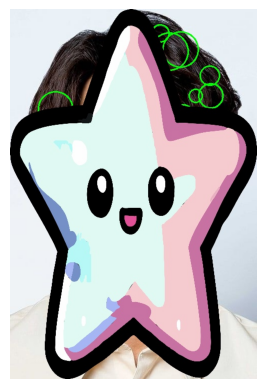

Options :
1. Apply Filter
2. Add Glasses to Eyes
3. Add Sticker to Face
4. Add Hat to Face
5. Save Image
6. Enter New Image
7. Exit
8. Detect line
9. Detect circles


In [ ]:
def main():
    flag = 1
    
    while True:
        image_path = input("Enter the image path or 'q' to quit: ")
        if image_path == 'q':
            break
        
        check = check_image_format(image_path)

        if check == None:
            continue
        
        image_copy_path = "image_copy.jpg" 
        image = cv2.imread(image_path)
        cv2.imwrite(image_copy_path, image)
        image = cv2.imread(image_copy_path)
        image_path = image_copy_path

        while True:
            print("Options :")
            print("1. Apply Filter")
            print("2. Add Glasses to Eyes")
            print("3. Add Sticker to Face")
            print("4. Add Hat to Face")
            print("5. Save Image")
            print("6. Enter New Image")
            print("7. Exit")
            print("8. Detect line")
            print("9. Detect circles")

            option = input("Enter option: ")

            if option == '1':
                while True:
                    filter_type = input("Choose filter ('grayscale', 'negative', 'color', 'brightnes', 'contrast', 'smoothing_g', 'smoothing_b', 'edge_laplace', 'edge_canny'): ")
                    filtered_image = apply_filters(image_path, filter_type)

                
                    if isinstance(filtered_image, Image.Image):
                        # Convert PIL Image to NumPy array
                        filtered_image = np.array(filtered_image)
                        if filtered_image.shape[2] == 3:  # If it's RGB
                            # Convert RGB to BGR
                            filtered_image = filtered_image[:, :, ::-1]

                    # Show image with the filter
                    cv2.imwrite(image_path, filtered_image)
                    image = cv2.imread(image_path)
                    show_image(image)
                    break


            elif option == '2':
                glasses_path = input("Enter path for the glasses image: ")
                
                if not os.path.isfile(glasses_path):
                    print("Invalid image path. Please try again.")
                    continue
                    
                image_with_glasses = add_glasses(image_path, glasses_path)
                
                cv2.imwrite(image_path, image_with_glasses)
                image = cv2.imread(image_path)
                # Εμφάνιση της εικόνας με τα γυαλιά στα μάτια
                show_image(image)

            elif option == '3':
                sticker_path = input("Enter path for the sticker image: ")
                
                if not os.path.isfile(sticker_path):
                    print("Invalid path. Please try again.")
                    continue
                               
                # Εντοπισμός κύκλων και προσθήκη αυτοκόλλητου στον πρώτο ανιχνευμένο κύκλο
                image_with_circles, circles = detect_circles(image_path)
                
                if circles is not None:
                    for (x, y, r) in circles[0]:
                        center = (x, y)
                        image_with_sticker = add_sticker(image_with_circles, center, sticker_path)
                        break
                
                cv2.imwrite(image_path, image_with_sticker)
                image = cv2.imread(image_path)
                # Εμφάνιση της εικόνας με το καπέλο στο πρόσωπο
                show_image(image)   

            elif option == '4':
                flag = 0
                hat_path = input("Enter path for the hat image: ")
                
                if not os.path.isfile(hat_path):
                    print("Invalid path. Please try again.")
                    continue

                image_with_hat = add_hat(image_path, hat_path)
                
                cv2.imwrite(image_path, image_with_hat)
                image = cv2.imread(image_path)
                # Εμφάνιση της εικόνας με το καπέλο στο πρόσωπο
                show_image(image)

           
            elif option == '5':
                img_name = input("Enter the name for your image: ")
                
                if flag == 0:
                    img_path = os.path.join('Memes', f"{img_name}.jpg")
                else:
                    img_path = os.path.join("Filtered_images", f"{img_name}.jpg")

                cv2.imwrite(img_path, image)
                print(f"Image saved successfully as {img_path}")

               

            elif option == '6':
                os.remove(image_copy_path)
                break
                
            elif option == '7':
                return

            elif option == '8':
                # Call your function
                detected_image, lines = detect_image_lines(image_path)

                # Check if lines were detected
                if lines is not None:
                    print(f"Detected {len(lines)} lines.")
                else:
                    print("No lines were detected.")

                # Show image with the filter
                cv2.imwrite(image_path, detected_image)
                image = cv2.imread(image_path)
                show_image(image)
                break

            elif option == '9':
                # Call the circle detection function
                processed_image, circles = detect_circles(image_path)

                # Check if any circles were detected
                if circles is not None:
                    print(f"Number of circles detected: {circles.shape[1]}")
                else:
                    print("No circles detected.")

                # Show image with the filter
                cv2.imwrite(image_path, processed_image)
                image = cv2.imread(image_path)
                show_image(image)
                break
                
                
                
                

            else:
                print("Invalid option. Please try again.")

if __name__ == "__main__":
    main()